In [128]:
from matplotlib import pyplot as plt
import networkx as nx
import random
import numpy as np

# Vector Field Plots

In [ ]:
from matplotlib import pyplot
import itertools
import scipy
def plot_vfield(alpha, sigma, beta, gamma):
#     alpha = 0.03
#     sigma = 1
#     beta = 0.3
#     gamma = 4

    cmap = pyplot.cm.viridis  # good for color blindness

    # Plot traces of how opinion and weight change over time
    for opinion, weight in [
        [0.25, 0.95], [0.45, 0.95], [0.55, 0.95], [0.65, 0.95], [0.75, 0.95],
        [0.85, 0.95], [0.95, 0.95], [0.35, 0.65], [0.45, 0.75], [0.95, 0.75],
        [0.95, 0.35], [0.3, 0.25], [0.3, 0.15], [0.15, 0.06], [0.05, 0.06]
    ]:
        ow = [[opinion, 0.0, weight]]
        for i in range(100):
            delta_o = sigma * alpha * ow[-1][2] * (ow[-1][1] - ow[-1][0])
            delta_w = (
                beta * ow[-1][2] * (1-ow[-1][2]) *
                (1-gamma*abs(ow[-1][1] - ow[-1][0])))
            new_weight = ow[-1][2] + delta_w
            if new_weight < 0.05:
                new_weight = 0
            ow.append([ow[-1][0] + delta_o, ow[-1][1] - delta_o, new_weight])
        pyplot.plot(
            [row[0] - row[1] for row in ow],
            [row[2] for row in ow],
            color=(cmap(0.15) if ow[-1][2] == 0 else cmap(0.75)),
            alpha=0.75)

    # Plot vector field
    opinion = scipy.linspace(0, 1, 11)  # the expected difference in opinion
    weight = scipy.linspace(0, 1, 11)   # the expected edge weight, E[w_ij]
    ow_grid = scipy.meshgrid(opinion, weight)
    delta_o_grid = -2*sigma*alpha * ow_grid[1] * ow_grid[0]
    delta_w_grid = beta * ow_grid[1] * (1-ow_grid[1]) * (1 - gamma * ow_grid[0])
    pyplot.quiver(ow_grid[0], ow_grid[1], delta_o_grid, delta_w_grid)

    # Annotate plot
    pyplot.xlabel('Expected opinion difference\nα='+str(alpha)+',β='+str(beta)+',σ='+str(sigma)+',γ='+str(gamma))
    pyplot.ylabel('Expected weight')
    pyplot.plot([0, 1], [0.05, 0.05], 'k--')
    pyplot.axis('square')
    pyplot.show()



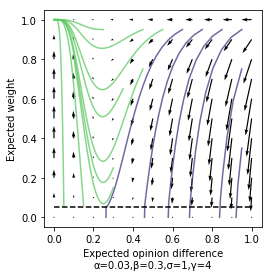

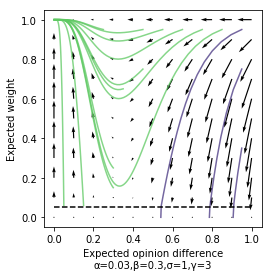

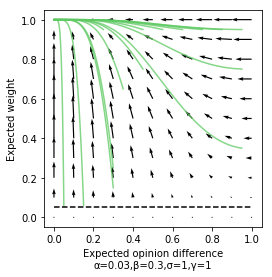

In [122]:
## Varying gamma
plot_vfield(alpha=.03, sigma=1, beta=.3, gamma=4)
plot_vfield(alpha=.03, sigma=1, beta=.3, gamma=3)
plot_vfield(alpha=.03, sigma=1, beta=.3, gamma=1)

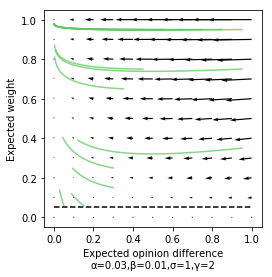

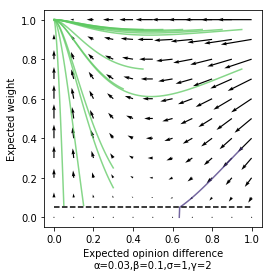

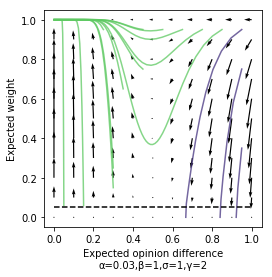

In [123]:
# Varying beta
plot_vfield(alpha=.03, sigma=1, beta=.01, gamma=2)
plot_vfield(alpha=.03, sigma=1, beta=.1, gamma=2)
plot_vfield(alpha=.03, sigma=1, beta=1, gamma=2)


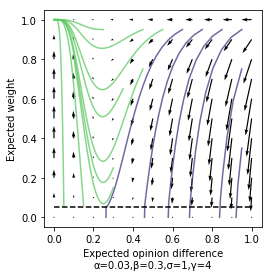

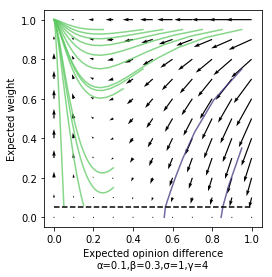

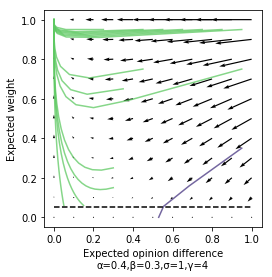

In [185]:
# Varying alpha
plot_vfield(alpha=.03, sigma=1, beta=.3, gamma=4)
plot_vfield(alpha=.1, sigma=1, beta=.3, gamma=4)
plot_vfield(alpha=.4, sigma=1, beta=.3, gamma=4)

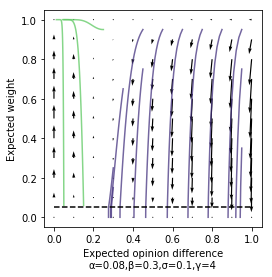

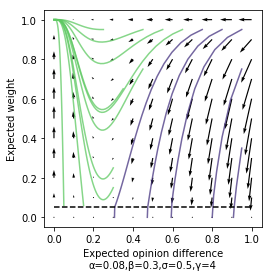

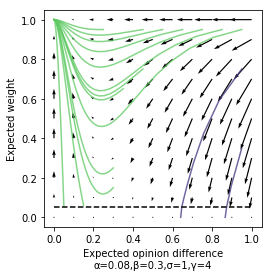

In [182]:
# Varying sigma
plot_vfield(alpha=.08, sigma=.1, beta=.3, gamma=4)
plot_vfield(alpha=.08, sigma=.5, beta=.3, gamma=4)
plot_vfield(alpha=.08, sigma=1, beta=.3, gamma=4)

In [134]:
np.random.normal(loc=1, scale=0.1, size=1)[0]

0.9269582044356862

# Part 3. Implementation

In [238]:
class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, num_op=1, op_popularity=[1], 
                 alpha=[0.03], beta=[0.3], gamma=4, weight_init=0.5,
                 charisma_mean=0.5):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.
              
            
            num_op (int) The number of sets of opinion. Defaul: 1
            
            op_popularity (list of floats): relative popularity of topics. The topic 
              chosen for each conversation is according to these relative popularity.
              Length of list equals num_op. Default: [1]

            alpha (list of floats) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions. Each opinion set 
              has its own alpha. Length of list equals num_op
              Default: [0.03].

            beta (list of floats) The rate at which edge weights are changed in
              response to differing opinions. Each opinion set has its own alpha. 
              Length of list equals num_op. Default: [0.3].

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
            
            weight_init (float) Value between 0.05 and 1 ( (0.05, 1] ). How to initialize 
              the weights. Default: 0.5
              
            charisma_mean (float) Value between 0 and 1 ( (0,1] ). When initializing
              the charismas for nodes, we draw from a normal distribution with mean equal 
              charisma_mean and std=0.1. If the sample is outside the range (0,1], then
              choose either 1 or 0.1, whichever is closer to the sample.
        '''
        if len(alpha) != num_op or len(beta) != num_op or len(op_popularity) != num_op:
            raise ValueError('`alpha` and `beta` must have the length of `num_op`')
        if weight_init > 1 or weight_init <= 0.05: 
            raise ValueError('weight_init must be in (0.05,1]')
        if charisma_mean > 1 or charisma_mean <=0:
            raise ValueError('charisma_mean must be in (0,1]')
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.num_op = num_op
        self.op_popularity = op_popularity
        self.weight_init = weight_init
        self.charisma_mean = charisma_mean

    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of self.weight_init.
        '''
#         self.graph = nx.watts_strogatz_graph(50, 5, 0.5)
        self.graph = nx.barabasi_albert_graph(self.network_size, 2)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = self.weight_init

        for node in self.graph.nodes:
            # set opinion vector randomly
            self.graph.nodes[node]['opinion'] = [random.uniform(0, 1) for _ in range(self.num_op)]
            
            # set charisma level randomly accoring to a normal distribution
            charisma = np.random.normal(loc=self.charisma_mean, scale=0.1, size=1)[0]
            # dealing with charisma outside the valid range
            if charisma > 1:
                charisma = 1
            elif charisma <= 0:
                charisma = 0.1
            self.graph.nodes[node]['charisma'] = charisma
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network according to a certain opinion.
        The holistic state of each node is taken to be the average of its
        opinion vector.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[np.sum(self.graph.nodes[i]['opinion'])/self.num_op for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))

    def update(self):
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            # randomly choosing the opinion set (ranging from 0 to num_op - 1)
            # this is the topic that the conversation is about. The topic is chosen
            # according to its relative level of popularity. 
            opinion_set = random.choices(range(self.num_op), weights=self.op_popularity, k=1)[0]
            
            # the two opinions of the two nodes
            opinions = [self.graph.nodes[n]['opinion'][opinion_set] for n in edge]
            
            # the two charismas of the two nodes
            charismas = [self.graph.nodes[n]['charisma'] for n in edge]
            # looping through each node of the pair being considered
            for i in [0, 1]: 
                # updating the opinion
                self.graph.nodes[edge[i]]['opinion'][opinion_set] = (
                    opinions[i] + charismas[1-i]*self.alpha[opinion_set]*weight*(opinions[1-i]-opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta[opinion_set] * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

## Code to show that expected opinion difference is around 0.2

In [253]:
def compute_expected_opinion_difference(network_size=200,num_op = 2):
    # initialize a BA graph
    graph = nx.barabasi_albert_graph(network_size, 2)
    for node in graph.nodes:
        # set opinion vector randomly
        graph.nodes[node]['opinion'] = [random.uniform(0, 1) for _ in range(num_op)]

    opinion_differences = []
    # loop over each edge
    for edge in list(graph.edges):
        # expected opinion of node 1 is the average of the opinion set
        opinion1 = np.sum(graph.nodes[edge[0]]['opinion'])/num_op
        # expected opinion of node 2 is the average of the opinion set
        opinion2 = np.sum(graph.nodes[edge[1]]['opinion'])/num_op
        # append to the list of opinion differences
        opinion_differences.append(abs(opinion2-opinion1))
    # return the expected opinion differences
    return np.sum(opinion_differences)/len(opinion_differences)

print(compute_expected_opinion_difference())
print(compute_expected_opinion_difference())
print(compute_expected_opinion_difference())
print(compute_expected_opinion_difference())
print(compute_expected_opinion_difference())

0.24343245801336136
0.23668580998130334
0.26376640578427535
0.22076237023698042
0.21811024931097528


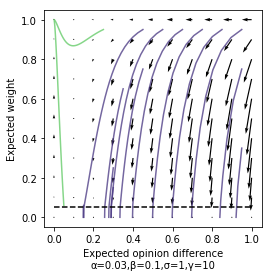

In [255]:
# corresponding vector field
plot_vfield(alpha=.03, sigma=1, beta=.1, gamma=10)

## Simulation where social cluster forms 

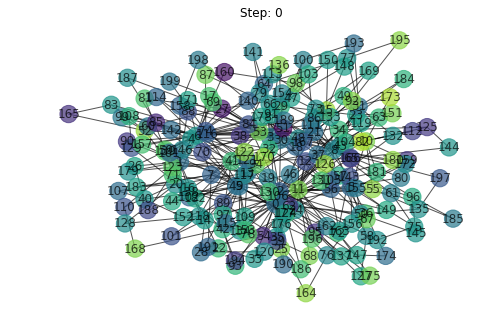

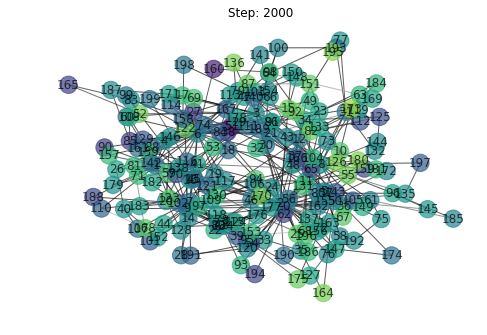

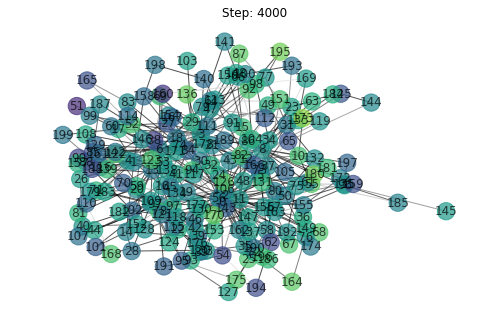

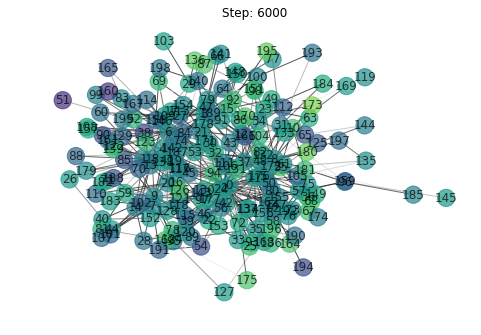

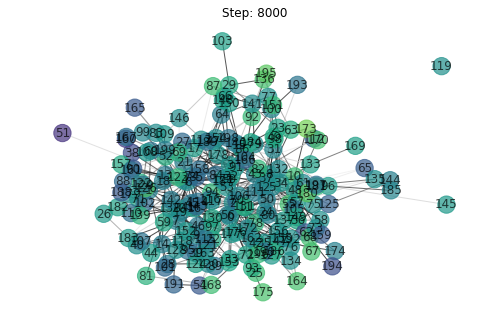

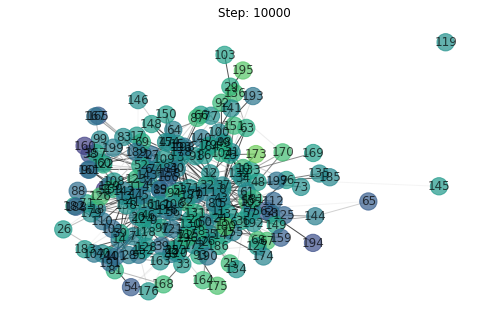

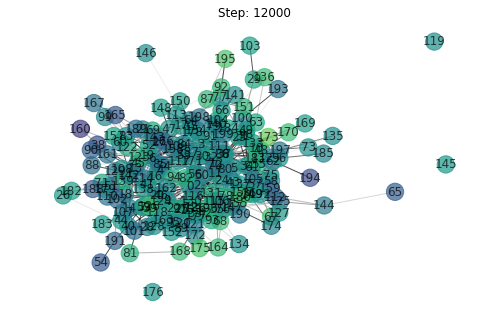

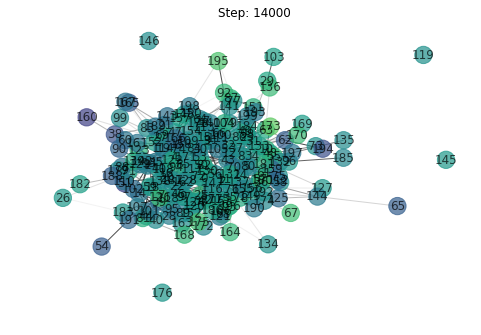

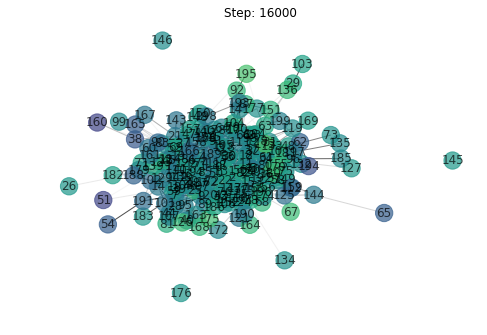

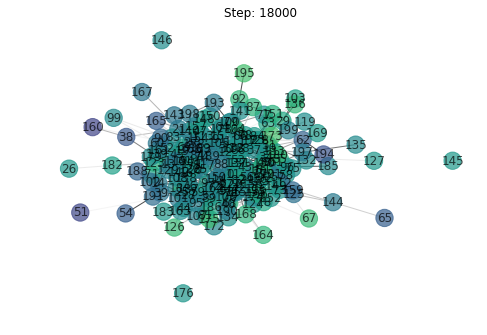

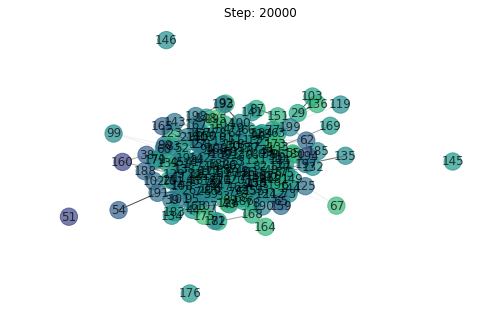

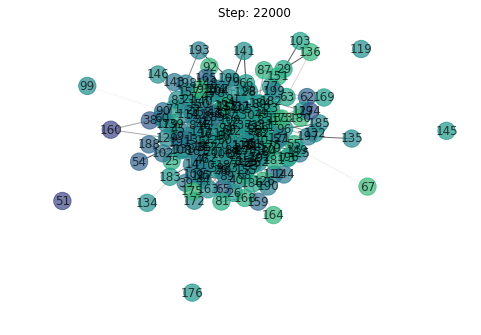

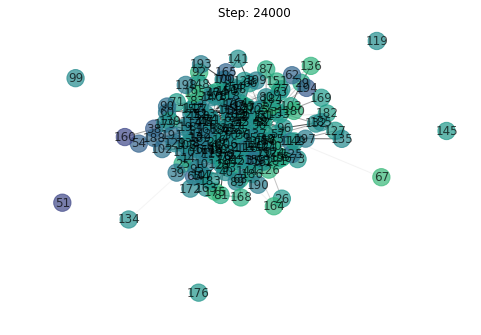

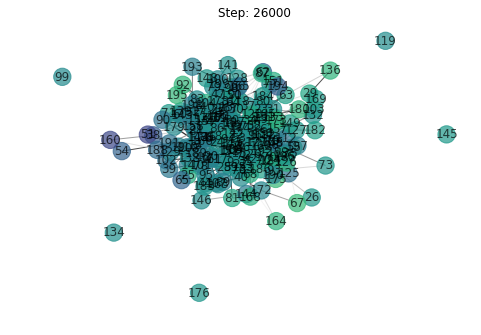

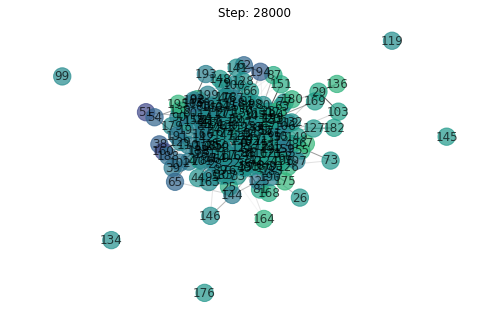

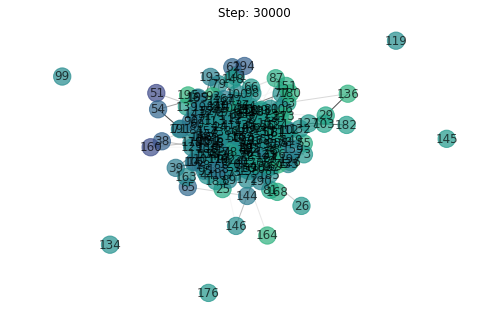

In [261]:
sim = SocialDynamicsSimulation(network_size=200,num_op=2, op_popularity=[1,1], 
                 alpha=[0.03,.03], beta=[0.1,0.1],  gamma=10,
                 weight_init=0.95, charisma_mean=1)
sim.initialize()
plt.figure()
sim.observe()
for i in range(15):
    for i in range(2000):
        sim.update()
    plt.figure()
    sim.observe()

## A simulation where social is split

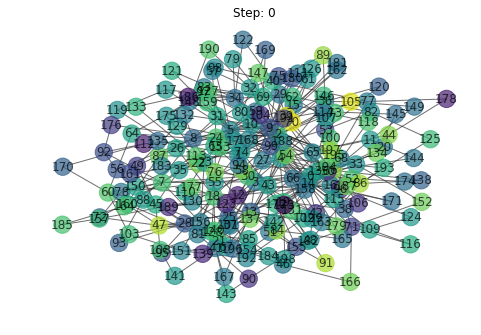

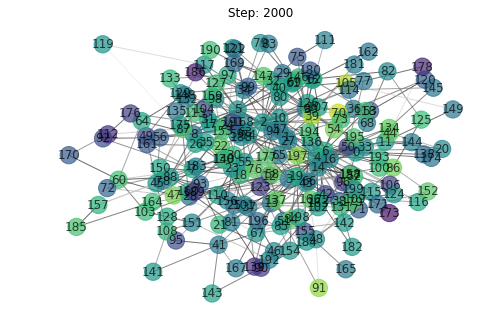

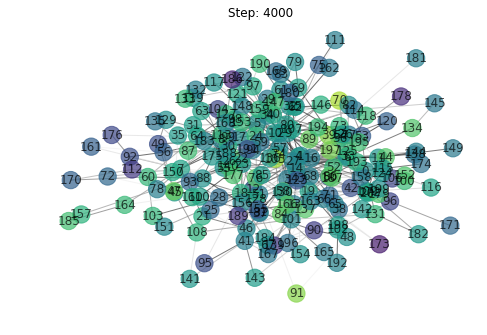

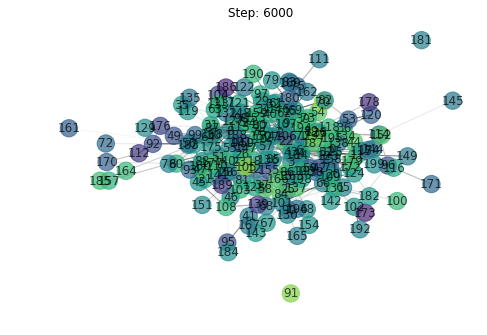

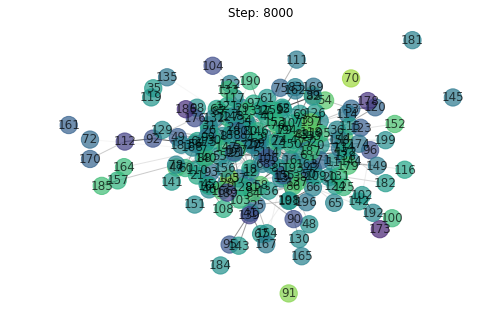

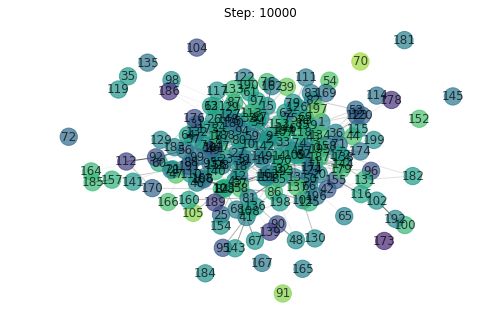

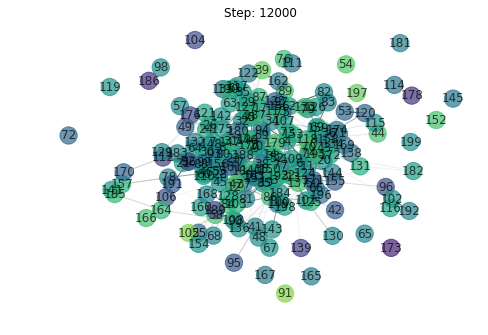

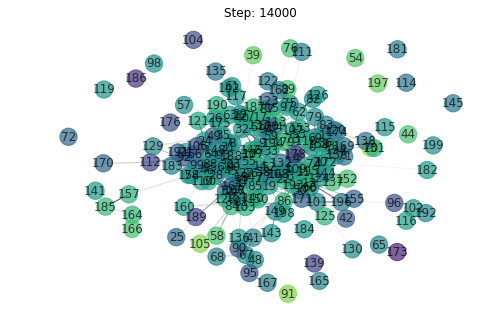

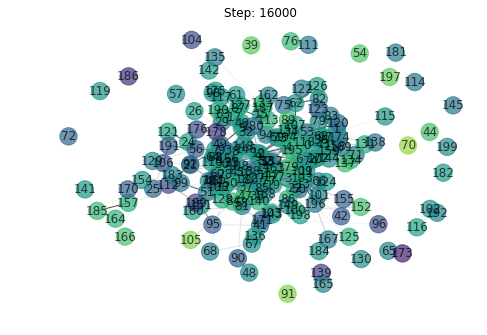

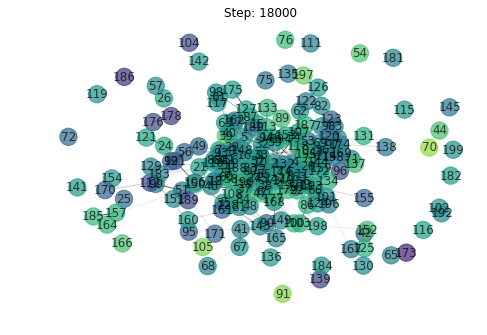

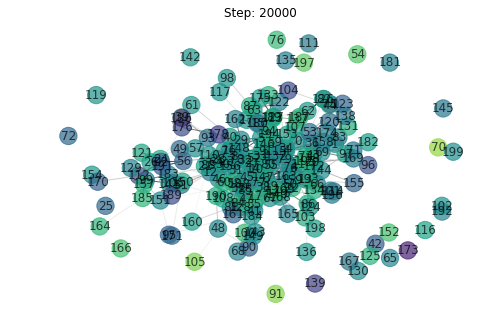

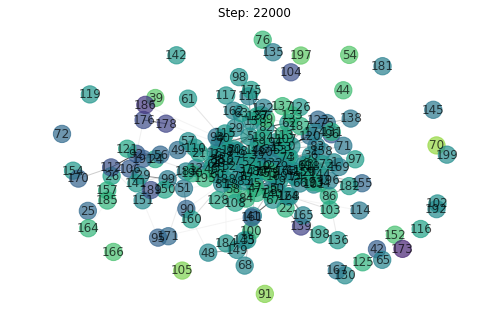

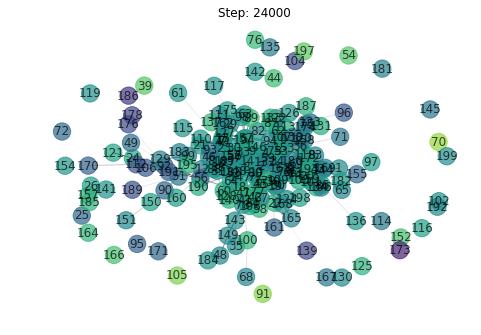

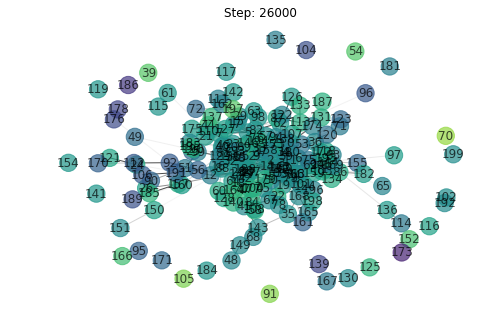

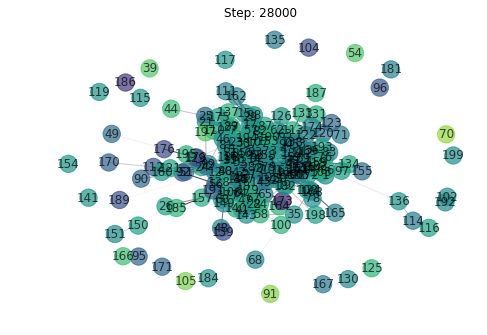

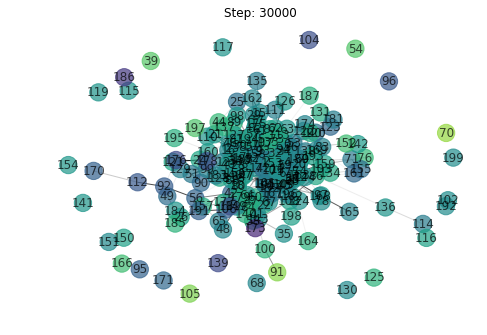

In [262]:
sim = SocialDynamicsSimulation(network_size=200,num_op=2, op_popularity=[1,1], 
                 alpha=[0.03,.03], beta=[0.1,0.1],  gamma=10,
                 weight_init=0.8, charisma_mean=1)
sim.initialize()
plt.figure()
sim.observe()
for i in range(15):
    for i in range(2000):
        sim.update()
    plt.figure()
    sim.observe()